# 네이버 쇼핑리뷰 감성 분류하기

- 위키독스 - https://wikidocs.net/94600

- 환경 : 구글 코랩 사용

# 1. Colab에 Mecab 설치

In [1]:
# Colab에 Mecab 설치

!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

# 코랩에서만 가능한 코드 
# 다른 환경이라면 거기에 맞는 코드로 설치해야함.

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 7.07 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 465 kB 49.7 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-11-03 12:01:04--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::6b17:d1f5, 2406:da00:ff00::22c5:2ef4, ...
Connecting to bitbucket.org (bi

# 2. 네이버 쇼핑 리뷰 데이터에 대한 이해와 전처리
- 다운로드 링크 : https://github.com/bab2min/corpus/tree/master/sentiment

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import urllib.request
from collections import Counter

from konlpy.tag import Mecab

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 데이터 불러오기 
 - 깃허브에 있는 데이터 불러오기

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", 
                           filename="ratings_total.txt")

# 데이터에는 열 제목이 없음.
# 컬럼명 설정
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])

# 전체 리뷰 개수 출력
print('전체 리뷰 개수 :', len(total_data)) 

# 샘플 확인
total_data[:3]

전체 리뷰 개수 : 200000


,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...


## 학습데이터와 테스트 데이터 분리하기.

In [4]:
total_data[['ratings']].value_counts()

ratings
5          81177
2          63989
1          36048
4          18786
dtype: int64

In [5]:
# 데이터에 label(y값) 이 없음
# 평점 4, 5인 리뷰를 1
# 평점 1, 2인 리뷰를 0 으로 label 컬럼 생성
np.select([total_data.ratings > 3], [1], default=0)
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)

# 결과 확인
total_data[:3]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1


In [6]:
# 컬럼별 중복을 제외한 샘플 수
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

# 총 20만개의 샘플데이터
# 중복 데이터가 존재함.

(4, 199908, 2)

In [7]:
# reviews 내용에 중복데이터 제고
total_data.drop_duplicates(subset=['reviews'], inplace=True)
print('총 샘플 수 :', len(total_data))

총 샘플 수 : 199908


In [8]:
# 결측치 확인
total_data.isna().sum()

ratings    0
reviews    0
label      0
dtype: int64

In [9]:
# 학습데이터 : 테스트 데이터 
# 비율 3 : 1 분리
train_data, test_data = train_test_split(total_data, 
                                         test_size  = 0.25, 
                                         random_state= 42)
print('훈련용   리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용   리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


## 데이터 정제하기

In [10]:
# 정규표현식 사용 
# 한글 제외하고 모두 제거 후 결측치 확인

# 학습 데이터
train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

train_data['reviews'].replace('', np.nan, inplace=True)
train_data.isna().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


ratings    0
reviews    0
label      0
dtype: int64

In [11]:
# 정규표현식 사용 
# 한글 제외하고 모두 제거 후 결측치 확인

# 테스트 데이터
test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

test_data['reviews'].replace('', np.nan, inplace=True)
test_data.isna().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


ratings    0
reviews    0
label      0
dtype: int64

In [12]:
# 전처리 후 샘플의 개수

print('전처리 후 학습   데이터 샘플 :', len(train_data))
print('전처리 후 테스트 데이터 샘플 :', len(test_data))

전처리 후 학습   데이터 샘플 : 149931
전처리 후 테스트 데이터 샘플 : 49977


## 토큰화

- 형태소 분석기 Mecab을 사용.

In [13]:
mecab = Mecab()
print(mecab.morphs('헐 내가 이걸 성공시켜???'))

['헐', '내', '가', '이걸', '성공', '시켜', '?', '??']


In [14]:
# 불용어를 지정하여 필용벗는 토큰을 제거
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', 
             '하', '고', '을', '를', '인', '듯', '과', '와', '네', 
             '들', '듯', '지', '임', '게']

In [15]:
# 학습 데이터
train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [16]:
# 테스트 데이터
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

## 단어와 길이 분포 확인하기
- 긍정리뷰에는 어떤 단어들이 많이 등장하고, <br>
  부정리뷰에는 어떤 단어들이 등장하는지 

- 두 가지 경우 빈도수 계산.

In [17]:
# 단어들을 리스트로 저장.
# 1 : 긍정 / 0 : 부정
np.hstack(train_data[train_data.label == 0]['tokenized'].values)
np.hstack(train_data[train_data.label == 1]['tokenized'].values)

negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

# counter() 를 사용하여 각 단어에 대한 빈도수 계산.
Counter(negative_words)
negative_word_count = Counter(negative_words)
positive_word_count = Counter(positive_words)
print('부정적인 단어 상위 3개 :', negative_word_count.most_common(3))
print('긍정적인 단어 상위 3개 :', positive_word_count.most_common(3))

부정적인 단어 상위 3개 : [('네요', 31799), ('는데', 20295), ('안', 19718)]
긍정적인 단어 상위 3개 : [('좋', 39488), ('아요', 21184), ('네요', 19895)]


긍정 리뷰의 평균 길이 : 13.587751456414221
부정 리뷰의 평균 길이 : 17.02953896259911


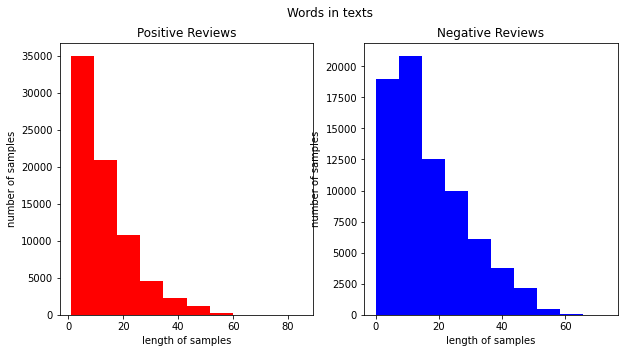

In [18]:
# 분포를 확인
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [19]:
train_data['tokenized'].values

array([list(['사이즈', '센치', '씩', '늘린', '건데', '작', '아요', '그리고', '색상', '완전', '달라요', '칙칙', '핑크', '네요', 'ㅠㅠ', '많이', '아쉽', '지만', '암막', '효과', '좋', '아요']),
       list(['ㅂ', '불', '만족', '빗이', '아픔', '멍', '피부', '빗', '질', '못해', '주', '겟', '네요']),
       list(['제품', '쓰', '삼', '일', '만', '변기', '물', '잘', '안', '내려갔', '어요', '혹시나', '해서', '다시', '빼', '보', '니', '물', '다시', '잘', '내려가', '네요', '많', '걸', '어쩌', '나요', '반품', '싶']),
       ..., list(['장', '주문', '안', '됩니다', '장', '가능', '해요']),
       list(['하림', '치킨', '여기', '서', '구입', '니', '엄청', '저렴', '네요', '배송', '쾅', '꽝', '얼', '어서', '도착', '아주', '만족', '합니다', 'ㅋㅋ']),
       list(['조금', '약해', '보이', '는데', '저렴', '잘', '삿', '어요'])], dtype=object)

In [20]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test = test_data['tokenized'].values
y_test = test_data['label'].values

## 정수 인코딩

- 학습 데이터와 테스트 데이터에 정수 인코딩을 수행.
- 단어 집합 만들기(vocaburary)

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [22]:
# 단어 집합이 생성되면서 단어에 고유한 정수가 부여됨.
tokenizer.word_index 

# 횟수가 1회인 단어들은 자연어 처리에서 배제.

{'네요': 1,
 '좋': 2,
 '어요': 3,
 '는데': 4,
 '아요': 5,
 '잘': 6,
 '있': 7,
 '구매': 8,
 '안': 9,
 '배송': 10,
 '습니다': 11,
 '했': 12,
 '너무': 13,
 '같': 14,
 '거': 15,
 '어': 16,
 '먹': 17,
 '합니다': 18,
 '되': 19,
 '재': 20,
 '요': 21,
 '기': 22,
 '쓰': 23,
 '않': 24,
 '없': 25,
 '것': 26,
 '아': 27,
 '해서': 28,
 '사용': 29,
 '로': 30,
 '았': 31,
 '나': 32,
 '으로': 33,
 '만': 34,
 '보다': 35,
 '었': 36,
 '주': 37,
 '겠': 38,
 '지만': 39,
 '보': 40,
 '아서': 41,
 '그냥': 42,
 '해': 43,
 '서': 44,
 '제품': 45,
 '면': 46,
 '어서': 47,
 '가격': 48,
 '해요': 49,
 '좀': 50,
 '만족': 51,
 '생각': 52,
 '주문': 53,
 '입니다': 54,
 '라': 55,
 '더': 56,
 '받': 57,
 '니': 58,
 '맛': 59,
 '할': 60,
 '많이': 61,
 '개': 62,
 '사': 63,
 '때': 64,
 '시': 65,
 '사이즈': 66,
 '에서': 67,
 '빠르': 68,
 '왔': 69,
 '샀': 70,
 '번': 71,
 '작': 72,
 '별로': 73,
 '음': 74,
 '맛있': 75,
 'ㅠㅠ': 76,
 '포장': 77,
 '입': 78,
 '수': 79,
 '두': 80,
 '맞': 81,
 '던': 82,
 '다른': 83,
 '저렴': 84,
 '괜찮': 85,
 '세요': 86,
 '넘': 87,
 '못': 88,
 '상품': 89,
 '정말': 90,
 '하나': 91,
 '아니': 92,
 '에요': 93,
 'ㅠ': 94,
 '냄새': 95,
 '데': 96,
 '부

In [23]:
# 단어들이 데이터에서 차지하는 비중 확인

threshold = 2

# 단어의 수
len(tokenizer.word_index)
total_cnt = len(tokenizer.word_index)

# 등장 빈도수가 threshold = 2 보다 작은 단어의 수 확인.
rare_cnt = 0

# 학습 데이터의 전체 단어 빈도수 총 합
total_freq = 0

# 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합
rare_freq = 0

In [24]:
# 단어와 빈도수의 쌍(pair)을 key 와 value로 

for key, value in tokenizer.word_counts.items() :
  # 학습 데이터의 전체 단어 빈도수 총합
  total_freq = total_freq + value

  # 단어의 등장 빈도수가 2보다 작으면
  if (value < threshold) :
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기                :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수       : %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율              :", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기                : 39997
등장 빈도가 1번 이하인 희귀 단어의 수       : 18212
단어 집합에서 희귀 단어의 비율              : 45.53341500612546
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 0.7935245745567578


In [25]:
# 전체 단어 개수 중 빈도수 2 이하인 단어 개수 제거
# 단어의 수 - 등장 빈도수 2 이하
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2

total_cnt - rare_cnt +2 
vocab_size = total_cnt - rare_cnt +2 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 21787


- 토크나이저 인자로 넘겨주고 
- 텍스트 시퀀스 → 정수 시퀀스 로 변환
- 정수 인코딩과정에서 vocab_size 보다 큰 숫자가 부여된 단어를 OOV로 변환

In [26]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [27]:
# 상위 3개만 
print(X_train[:3])
print(X_test[:3])

[[67, 2060, 299, 14260, 263, 73, 6, 236, 168, 137, 805, 2951, 625, 2, 77, 62, 207, 40, 1343, 155, 3, 6], [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2], [46, 24, 825, 105, 35, 2372, 160, 7, 10, 8061, 4, 1319, 29, 140, 322, 41, 59, 160, 140, 7, 1916, 2, 113, 162, 1379, 323, 119, 136]]
[[14, 704, 767, 116, 186, 252, 12], [339, 3904, 62, 3816, 1651], [11, 69, 2, 49, 164, 3, 27, 15, 6, 513, 289, 17, 92, 110, 564, 59, 7, 2]]


## 패딩

- 서로 다른 길이의 문장을 동일하게 맞춰주는 작업.

In [28]:
# 전체 데이터에서 긴 리뷰와 짧은 리뷰 확인.
max(len(review) for review in X_train)
round(sum(map(len, X_train)) / len(X_train), 2)

print('리뷰 최대 길이 :', max(len(review) for review in X_train))
print('리뷰 평균 길이 :', round(sum(map(len, X_train)) / len(X_train), 2))

리뷰 최대 길이 : 85
리뷰 평균 길이 : 15.31


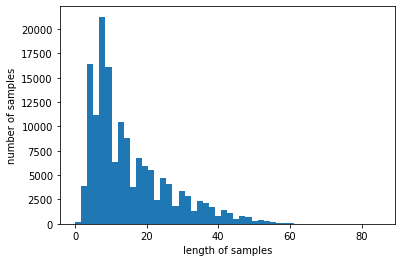

In [29]:
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show();

In [30]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

# 길이가 80으로 패딩할 경우 몇개의 샘플을 보전할 수 있는지?
max_len = 80
below_threshold_len(max_len, X_train)

# 리뷰의 99% 80이하의 길이를 가짐.

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [31]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# GRU 리뷰 감성 분류하기

- 하이퍼 파라미터 임베딩 백터의 차원 : 100
- 은닉 상태의 크기 : 128
- 다 대 일 구조의 LSTM 사용
- 이진 분류
  - 출력층 : 로지스틱 회귀를 사용 = 시그모이드(sigmoid) 함수사용
  - 손실함수 = 크로스 엔트로피(binary_crossentropy) 함수 사용

- 배치사이즈 : 64
- 학습 15


- EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
  - 검증데이터 손실(val_loss) 증가하면 과적합
  - 검증데이터 손실(val_loss) 4회 증가하면 정해진 epoch가 도달하지 않아도 학습을 조기 종료(EarlyStooping).

- ModelCheckpoint : 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장.

- validation_split=0.2 : 훈련데이터의 20%를 검증데이터로 분리해서 사용해서 학습 잘 되는지 확인.<br>
  검증 데이터는 기계가 훈련 데이터에 과적합되고 있는지 않은지 확인하기 위한 용로도 사용.

In [32]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2178700   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,267,149
Trainable params: 2,267,149
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, 
                    epochs=15, callbacks=[es, mc], 
                    batch_size=60, validation_split=0.2)

Epoch 1/15
2000/2000 [==============================] - ETA: 0s - loss: 0.2711 - acc: 0.8970
Epoch 1: val_acc improved from -inf to 0.91990, saving model to best_model.h5
2000/2000 [==============================] - 354s 175ms/step - loss: 0.2711 - acc: 0.8970 - val_loss: 0.2236 - val_acc: 0.9199
Epoch 2/15
2000/2000 [==============================] - ETA: 0s - loss: 0.2139 - acc: 0.9229
Epoch 2: val_acc did not improve from 0.91990
2000/2000 [==============================] - 361s 180ms/step - loss: 0.2139 - acc: 0.9229 - val_loss: 0.2232 - val_acc: 0.9169
Epoch 3/15
2000/2000 [==============================] - ETA: 0s - loss: 0.1980 - acc: 0.9285
Epoch 3: val_acc improved from 0.91990 to 0.92533, saving model to best_model.h5
2000/2000 [==============================] - 351s 175ms/step - loss: 0.1980 - acc: 0.9285 - val_loss: 0.2100 - val_acc: 0.9253
Epoch 4/15
2000/2000 [==============================] - ETA: 0s - loss: 0.1871 - acc: 0.9333
Epoch 4: val_acc did not improve from 0.92

In [34]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 38s 24ms/step - loss: 0.2095 - acc: 0.9246

 테스트 정확도: 0.9246


# 리뷰 예측하기

In [35]:
# 임의 문장에 대한 예측
# 학습 하기 전 전처리 동일하게 처리.
# 전처리의 순서 : 정규 표현식을 통한 한국어 외 문자 제거→토큰화→불용어 제거→정수 인코딩→패딩 순

def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [36]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

1/1 [==============================] - 0s 481ms/step
97.56% 확률로 긍정 리뷰입니다.


In [37]:
sentiment_predict('질긴면은 있는데 맛이 있어요')

1/1 [==============================] - 0s 37ms/step
66.17% 확률로 긍정 리뷰입니다.


In [39]:
sentiment_predict('배송만 빨라요 제품은 .....')

1/1 [==============================] - 0s 40ms/step
56.35% 확률로 부정 리뷰입니다.


In [40]:
sentiment_predict('배송만 빨라요.....')

1/1 [==============================] - 0s 34ms/step
61.39% 확률로 긍정 리뷰입니다.


In [41]:
sentiment_predict('다른곳이 더 싸요')

1/1 [==============================] - 0s 43ms/step
85.34% 확률로 부정 리뷰입니다.




---

